**Rappel de la mission**

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

In [7]:
#!pip install catboost 
#!git clone --recursive https://github.com/Microsoft/LightGBM
#!pip install lightgbm
#!pip install xgboost
#!pip install imblearn


In [1]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile
import time

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [4]:
z = ZipFile("./data/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [5]:
TARGET = pd.read_csv('./data/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### Baseline model - Logistic Regression

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
# def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
#     '''This function will make a pretty plot of 
#   an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
#     fig = plt.figure(figsize=(20,15))
  
#     plt.subplot(221)
#     cf_matrix = confusion_matrix(y_true, y_pred)
#     group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
#     group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

#     plt.subplot(222)
#     fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
#     plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
#     plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()

#     if feature_importances : 
#         plt.subplot(212)
#         indices = np.argsort(model.feature_importances_)[::-1]
    
#     features = []
    
#     for i in range(20):
#         features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

#     sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
#     plt.xlabel('Features importance')
#     plt.xticks(rotation=90)

#     show()

In [9]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=None, X_data=None):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances and X_data is not None: 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
    
        for i in range(20):
            features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

    plt.show()


In [10]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: total: 3.8 s
Wall time: 1.84 s


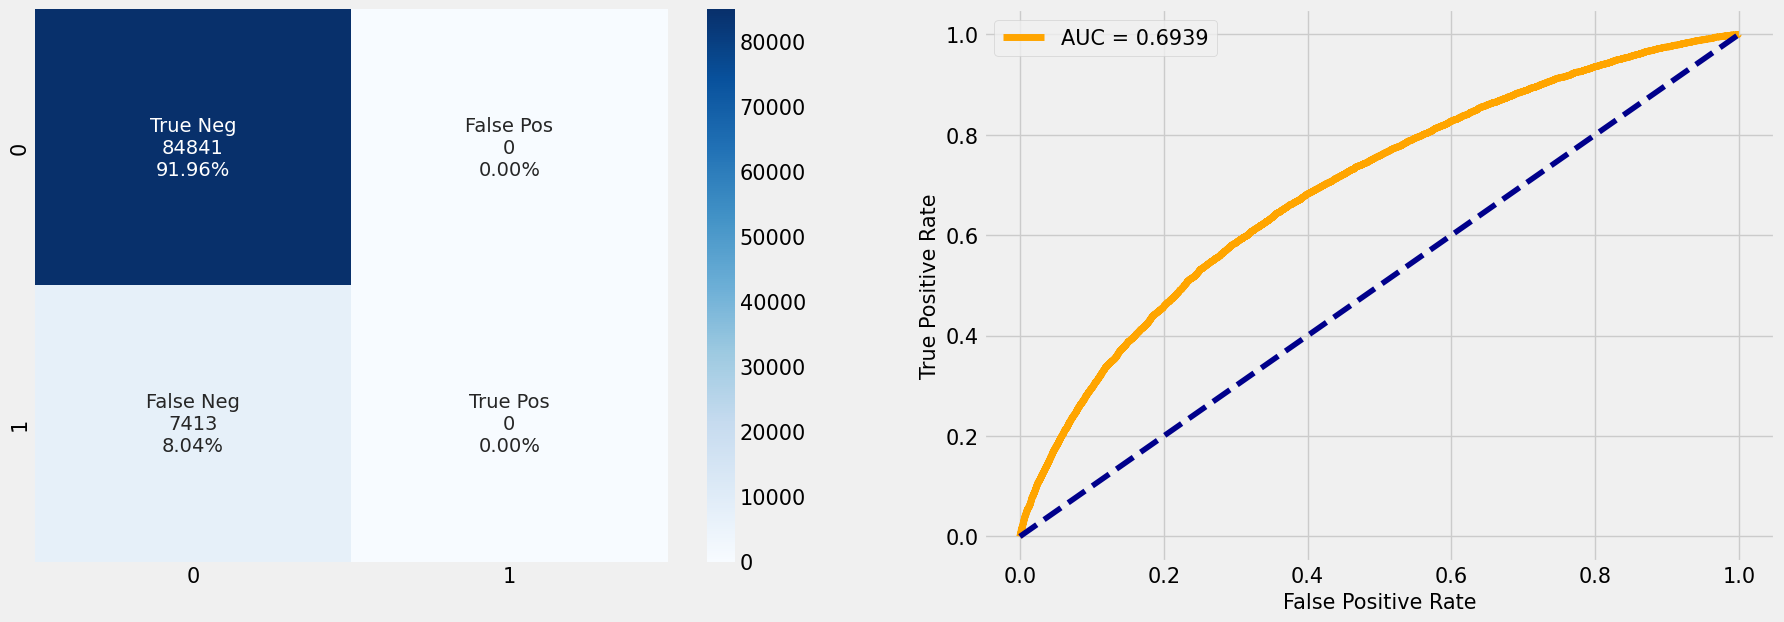

In [11]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

Amélioration de l'AUC score 0.69 que nous prendrons comme baseline de travail pour la suite des essais…



### Gradient Boosting

In [12]:
# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
    CatBoostClassifier(task_type="CPU", logging_level='Silent'),
    LGBMClassifier(device='cpu'),
    XGBClassifier(tree_method='hist', predictor='cpu_predictor')
]


La fonction suivante train_models peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux Scoring de Classification de Scikit-learn.

In [13]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [14]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 6min 54s
Wall time: 3min 5s


In [15]:
base_models


,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.777892,0.91944,0.486639,0.046675,0.08518,163.339204
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,8.446281
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,13.87145


**Oversampling Data Using SMOTE**

In [16]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [17]:
%%time

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: total: 7.33 s
Wall time: 4.06 s


In [18]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [19]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: total: 16.4 s
Wall time: 5.64 s


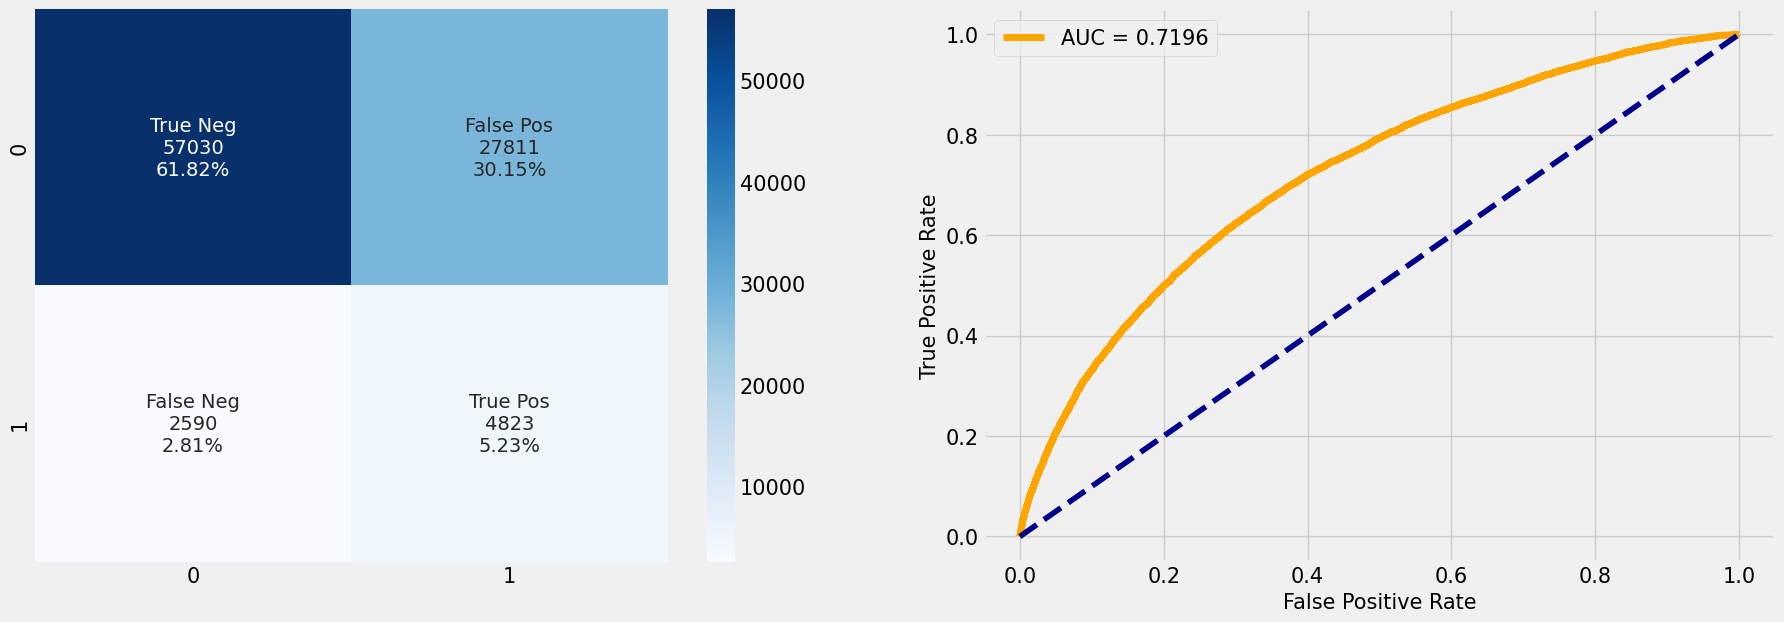

In [20]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [21]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 18min 1s
Wall time: 5min 27s


In [22]:
models_res


,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.77064,0.919592,0.496887,0.053824,0.097128,293.658404
2,XGBClassifier,0.753275,0.918182,0.430341,0.056253,0.099499,20.994493
1,LGBMClassifier,0.75241,0.918865,0.398876,0.019156,0.036556,13.075452


LGBMClassifier reste le "plus performant" selon le couple métrique/temps

### Feature Selection - Recursive Feature Elimination

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

RFECV signifie "Recursive Feature Elimination with Cross-Validation". C'est une méthode pour sélectionner les meilleures caractéristiques en utilisant la validation croisée. L'idée de base de la RFE est de supprimer récursivement des attributs et de construire un modèle sur les attributs qui restent. RFECV effectue RFE en boucle, où à chaque itération, il utilise la validation croisée pour évaluer les performances du modèle et détermine le nombre optimal de caractéristiques.



In [23]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [24]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 119
Selected Features: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1 16  8  1  1  1  1  1  1  1  1  1  1 18 19  1 19 19 11]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [25]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

119
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_AMT_CREDIT', 'PREV_APPL_MEAN_AMT_APPLICATION', 'PREV_APPL_MEAN_AMT_ANNUITY', 'PREVIOUS_APPLICATION_COUNT', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NOMBRE_PRETS_PRECEDENTS', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 'PREV_BUR_MEAN

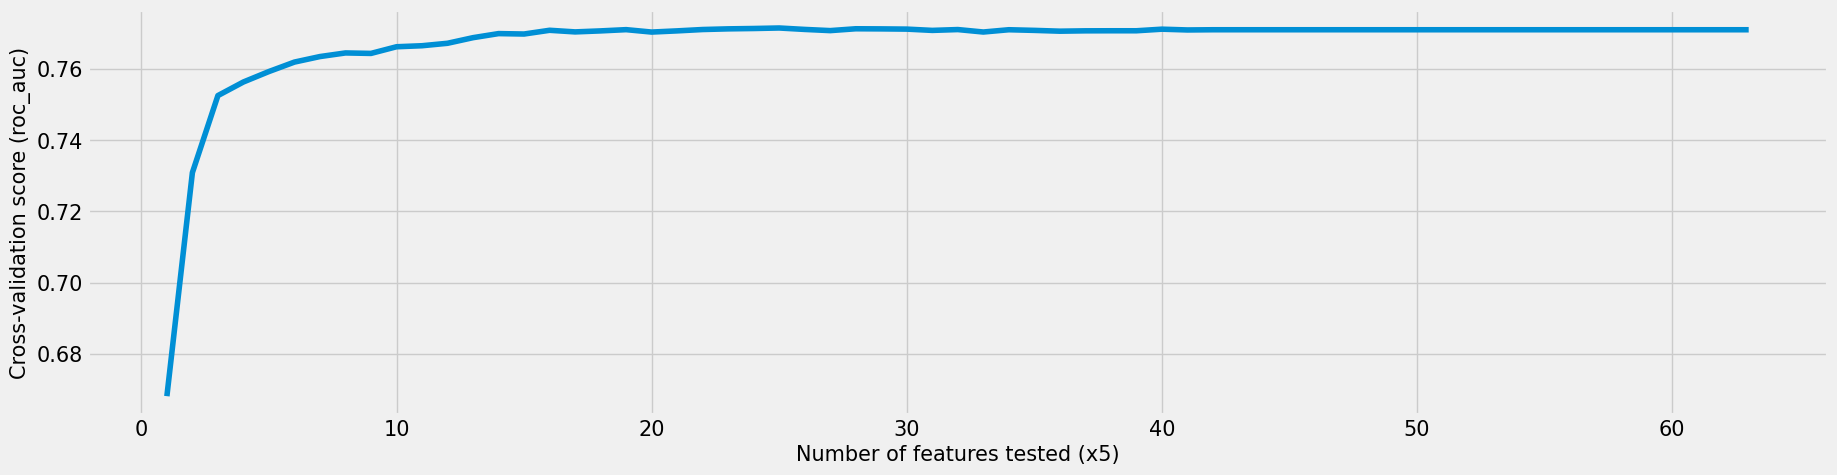

In [26]:
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
show()


RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [27]:
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape


(307511, 119)

In [28]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('./data/X_data.zip', index=True, compression=compression_opts)

CPU times: total: 58.1 s
Wall time: 1min 18s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 119 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [29]:
#Transform data avec rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [30]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="cPU", logging_level='Silent'),
          LGBMClassifier(device='cpu'),
          XGBClassifier(tree_method='cpu_hist', predictor='cpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [31]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 4min 2s
Wall time: 1min 19s


In [32]:
# Performance des modèles avec la sélection de caractéristiques
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.778746,0.920166,0.532787,0.05261,0.095764,65.804644
1,LGBMClassifier,0.773934,0.920166,0.553571,0.033455,0.063096,6.381361
2,XGBClassifier,0.763453,0.918995,0.466667,0.056657,0.101047,7.483558


In [33]:
###models avant sélection de caractéristiques
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.777892,0.91944,0.486639,0.046675,0.08518,163.339204
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,8.446281
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,13.87145


LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time. CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

**__________________________________________________________________________________________________________**

Dans la dernière partie de l'étude on développera les 3 volets suivants : **La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation.**

**La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive)** : les cas où la prédiction est positive, mais où la valeur réelle est négative.

Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

**FN (False Negative)** : les cas où la prédiction est négative, mais où la valeur réelle est positive.

Perte réelle si le crédit client accepté se transforme en défaut de paiement.

**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**

L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

![Description de image](./photo/1.png)


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:

![Description de image](./photo/2.png)

Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall :

![Description de image](./photo/3.png)

Explication sur la F-measure Wikipedia

**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β)**. Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.

- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

![Description de image](./photo/4.png)

On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.

In [34]:
# Tests fonctionnels avec des listes contenant 4 entiers : tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [35]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [36]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### Hyperparameters tunning - Hyperopt et AUC score

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [37]:
#!pip install hyperopt

In [38]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval


In [39]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [40]:
space

{'n_estimators': <hyperopt.pyll.base.Apply at 0x16169b1a680>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x16169b1aef0>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x16169b1b250>,
 'subsample': <hyperopt.pyll.base.Apply at 0x16169b1b730>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x16169b1b610>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x16169b1aec0>}

In [41]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        #'device':'cpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [42]:
%%time
best = fmin(fn=objective, space=space, max_evals=30,  rstate=np.random.seed(1), algo=tpe.suggest)

100%|████████████████████████████████████████████████| 30/30 [27:35<00:00, 55.20s/trial, best loss: 0.9769959069739819]
CPU times: total: 2h 44min 5s
Wall time: 27min 36s


In [43]:
%%time
lgbm = LGBMClassifier( 
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    #device='gpu'
)

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("./models/LGBMClassifier.pkl", "wb"))

CPU times: total: 1min 56s
Wall time: 17.4 s


In [44]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779986


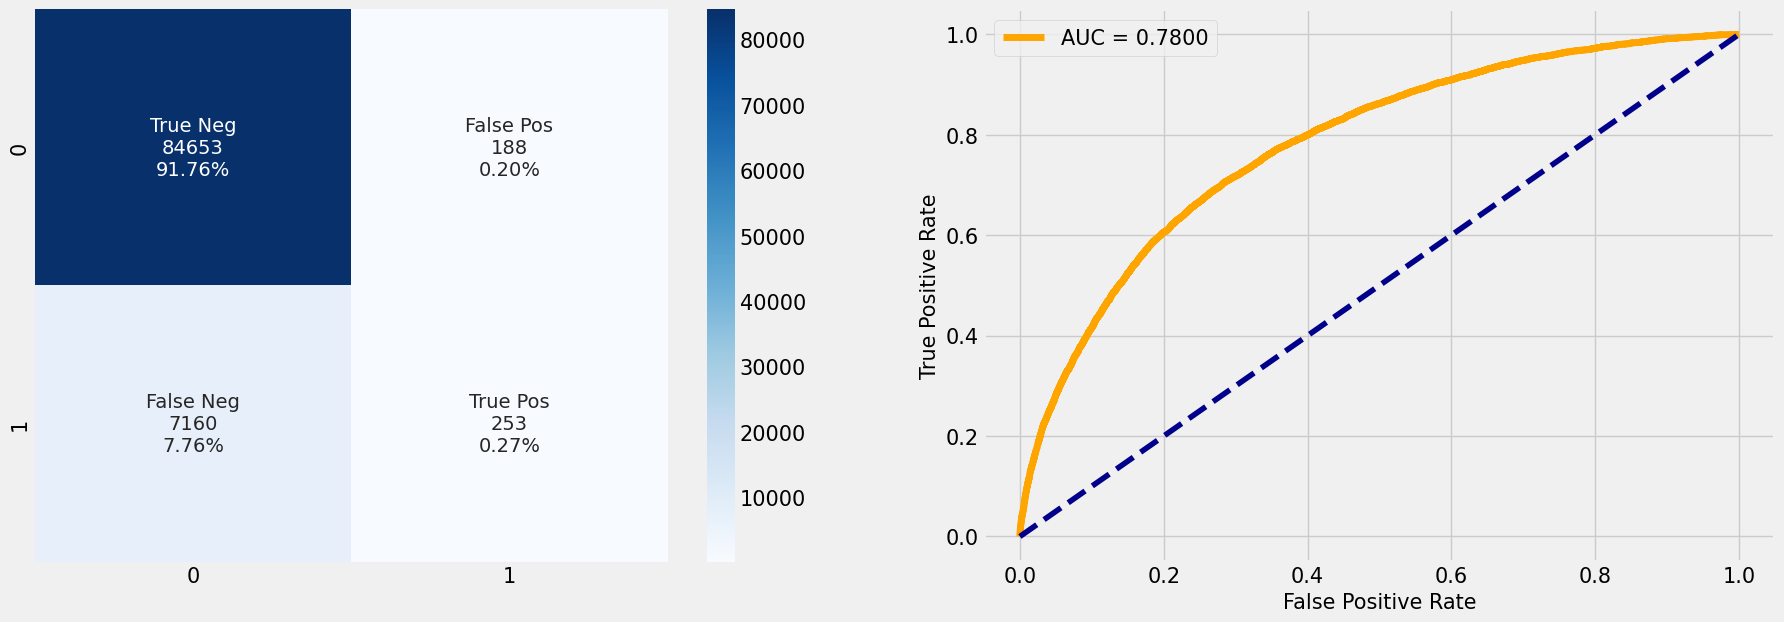

In [45]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)


In [46]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.20%
False Neg: 7.76%


(0.0020378520172567045, 0.07761181086998938)

In [47]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 907]
['EXT_SOURCE_1', 683]
['EXT_SOURCE_3', 604]
['DAYS_BIRTH', 587]
['EXT_SOURCE_2', 543]
['PREV_APPL_MEAN_CNT_PAYMENT', 443]
['AMT_ANNUITY', 428]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 394]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 370]
['DAYS_ID_PUBLISH', 351]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 342]
['ANNUITY_INCOME_PERCENT', 326]
['AMT_GOODS_PRICE', 317]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 299]
['AMT_CREDIT', 296]
['PREV_BUR_MEAN_DAYS_CREDIT', 289]
['DAYS_REGISTRATION', 275]
['PREV_APPL_MEAN_AMT_ANNUITY', 255]
['DAYS_LAST_PHONE_CHANGE', 254]
['DAYS_EMPLOYED', 250]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 245]
['DAYS_EMPLOYED_PERCENT', 243]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 241]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 240]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 238]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 237]
['CREDIT_INCOME_PERCENT', 231]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 221]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 205]
[

In [48]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        #'device':'gpu'
    }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [49]:
%%time
best = fmin(fn=objective, space=space, max_evals=30,  rstate=np.random.seed(1), algo=tpe.suggest)

100%|███████████████████████████████████████████████| 30/30 [26:47<00:00, 53.60s/trial, best loss: 0.22174687300141094]
CPU times: total: 2h 53min 1s
Wall time: 26min 47s


In [50]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("./models/LGBMClassifier2.pkl", "wb"))

CPU times: total: 1min 53s
Wall time: 17.8 s


In [51]:
%%time
lgbm = LGBMClassifier( 
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu',
    verbose=0  # Ajoutez cette ligne
)

lgbm.fit(X_train_selected, y_train)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119360 seconds.
You can set `force_col_wise=true` to remove the overhead.
CPU times: total: 1min 53s
Wall time: 17.9 s


LGBMClassifier(colsample_bytree=0.6660156616882186, device='cpu',
               learning_rate=0.029856457556175525, max_depth=7,
               n_estimators=600, reg_lambda=14.635251237609168,
               subsample=0.8155011393426, verbose=0)

In [52]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780007


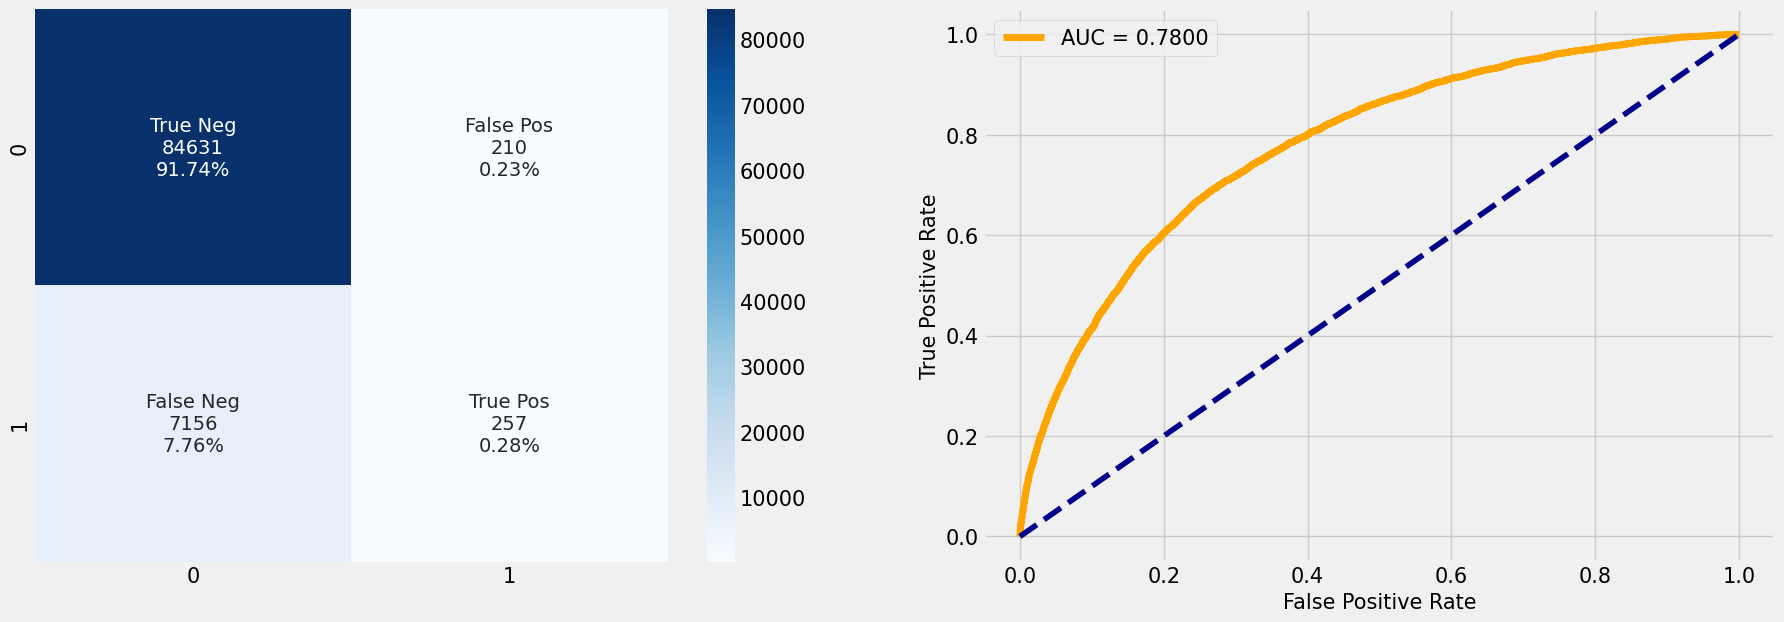

In [53]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)


In [54]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.23%
False Neg: 7.76%


(0.0022763240618292975, 0.07756845231643072)

In [55]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 898]
['EXT_SOURCE_1', 679]
['EXT_SOURCE_3', 580]
['DAYS_BIRTH', 574]
['EXT_SOURCE_2', 568]
['PREV_APPL_MEAN_CNT_PAYMENT', 431]
['AMT_ANNUITY', 407]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 381]
['DAYS_ID_PUBLISH', 367]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 366]
['AMT_GOODS_PRICE', 337]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 331]
['PREV_BUR_MEAN_DAYS_CREDIT', 317]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 307]
['DAYS_REGISTRATION', 306]
['ANNUITY_INCOME_PERCENT', 301]
['AMT_CREDIT', 284]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 274]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 272]
['DAYS_LAST_PHONE_CHANGE', 267]
['PREV_APPL_MEAN_AMT_ANNUITY', 265]
['DAYS_EMPLOYED', 251]
['DAYS_EMPLOYED_PERCENT', 245]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 237]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 234]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 222]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 206]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 204]
['PREV_BUR_MEAN_DAYS_ENDDATE_F

**Conclusion**

Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 119. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

### MLflow

MLflow est une plateforme ouverte pour le cycle de vie complet de l'apprentissage automatique. Elle permet de suivre les expériences, de regrouper les artefacts d'un projet de machine learning et de partager et reproduire des runs.

In [56]:
#!pip install mlflow

In [57]:
# import mlflow
# import mlflow.lightgbm
# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score

# def train_lgbm_with_mlflow(params):
    
#     # Démarrer une expérience MLflow
#     with mlflow.start_run():
#         # Entraîner le modèle
#         model = LGBMClassifier(**params)
#         model.fit(X_train, y_train)
#         predictions = model.predict(X_test)
        
#         # Évaluer le modèle
#         accuracy = accuracy_score(y_test, predictions)
        
#         # Enregistrer les paramètres, métriques et modèle dans MLflow
#         mlflow.log_params(params)
#         mlflow.log_metric("accuracy", accuracy)
#         mlflow.lightgbm.log_model(model, "model")


In [58]:
# import mlflow
# import mlflow.lightgbm
# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report

# def train_models(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     output = {
#         'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
#         'Accuracy': accuracy_score(y_test, model.predict(X_test)),
#         'Precision': precision_score(y_test, model.predict(X_test)),
#         'Recall': recall_score(y_test, model.predict(X_test)),
#         'F1': f1_score(y_test, model.predict(X_test))
#     }
#     return output


# def train_lgbm_with_mlflow(params):
#     # Démarrer une expérience MLflow
#     with mlflow.start_run():
#         # Entraîner et évaluer le modèle
#         model = LGBMClassifier(**params)
#         results = train_models(model, X_train, X_test, y_train, y_test)

#         # Enregistrer les métriques dans MLflow
#         for metric_name, metric_value in results.items():
#             mlflow.log_metric(metric_name, metric_value)

#         mlflow.lightgbm.log_model(model, "model")


# #train_lgbm_with_mlflow(params)

# param_grid = {
#     'num_leaves': [31, 50, 75, 100],
#     'min_data_in_leaf': [10, 20, 30, 40],
#     'max_depth': [4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     # ajoutez d'autres paramètres si nécessaire
# }


# grid_model = LGBMClassifier()

# grid = GridSearchCV(
#     estimator=grid_model,
#     param_grid=param_grid,
#     cv=3,  # nombre de folds pour la validation croisée
#     scoring='roc_auc',  # vous pouvez choisir d'autres métriques comme 'accuracy'
#     verbose=1,
#     n_jobs=-1  # utilise tous les cœurs disponibles
# )


# grid_result = grid.fit(X_train, y_train.ravel())
# best_params = grid_result.best_params_
# print("Meilleurs paramètres:", best_params)

# train_lgbm_with_mlflow(best_params)

In [59]:
# mlflow ui